In [1]:
import pickle
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

In [25]:
TEMPLATE_NAMES = ['8-1', '8-2', '8-3', '8-4', '8-5', '16-1', '16-2', '16-3', '16-4', '19']
ALKYNE_NAMES   =  ['22-1', '22-2', '22-3', '22-4', '22-5', '22-6', 
                  '22-7', '22-8', '22-9', '22-10', '22-11', '22-12',
                  '22-13', '22-14', '22-15', '22-16', '22-17',
                  '22-18', '22-19', '22-20', '22-21', '22-22', 
                  '22-23', '22-24', '22-25', '22-26', '22-27']

# "intuitive" descriptors selected from mordred
MORD_DESC_NAMES = [
    'nHeavyAtom', 
    'nHetero', 'C1SP2', 'C2SP2', 'C3SP2', 
    'C1SP3', 'SLogP', 'HybRatio', 'nHBDon', 'apol', 
    'bpol', 'nRot', 'RotRatio', 'TopoPSA', 'Diameter', 'Radius', 'MW',
]

# helper functions
def get_descriptors(frag_name, desc_names, desc):
    ''' frag_name: string name of the fragment
        desc_names: list of descritpors names to be considered
        desc: dataframe of the descriptors
    '''
    desc_vec = []
    for desc_name in desc_names:
        val = desc[desc['name']==frag_name][desc_name].tolist()[0]
        desc_vec.append(val)

    return desc_vec


def make_dataset(df_lookup, desc_alky, desc_temp):
    ''' generate the entire dataset
    '''
    desc_alky_names = ['-'.join(['alkyne', key]) for key in MORD_DESC_NAMES]
    desc_temp_names = ['-'.join(['template', key]) for key in MORD_DESC_NAMES]
    
    # is_feas = 0 (1) if (in)feasible
    all_data = {'alkyne': [], 'template': [], 'is_feas': [], 'abl1_pIC50_obj': [] }
    for desc_name in desc_alky_names+desc_temp_names:
        all_data[desc_name] = []
        
    # lookup table contains all the data in this case
    for ix, row in df_lookup.iterrows():
        row = row.to_dict()
        template_name = row['template_name']
        alkyne_name = row['alkyne_name']
        
        desc_vec_alky = get_descriptors(alkyne_name, MORD_DESC_NAMES, desc_alky)
        desc_vec_temp = get_descriptors(template_name, MORD_DESC_NAMES, desc_temp)
        
        is_feas = np.abs(row['synthesis_success'] - 1)
        
        if is_feas == 0:
            # successful experiment, feasible measurement of pIC50
            abl1_pIC50_obj = row['abl1_pIC50']
        elif is_feas == 1:
            # failed synthesis, infeasible measurements of pIC50
            abl1_pIC50_obj = np.nan
        
        all_data['alkyne'].append(alkyne_name)
        all_data['template'].append(template_name)
        
        all_data['abl1_pIC50_obj'].append(abl1_pIC50_obj)
        all_data['is_feas'].append(is_feas)

        for key, val in zip(desc_alky_names, desc_vec_alky):
            all_data[key].append(val)
            
        for key, val in zip(desc_temp_names, desc_vec_temp):
            all_data[key].append(val)
    
    
    
    return pd.DataFrame(all_data)



In [20]:
# load in the lookup
df_lookup = pd.read_csv('lookup_table.csv')
print(df_lookup.shape)
df_lookup.head()

(270, 10)


,template_name,alkyne_name,template_smi,alkyne_smi,molecule_smi,synthesis_success,synthesis_success_prob,is_experiment_x,abl1_pIC50,abl1_pIC50_std
0,8-1,22-1,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,C#Cc1cnc2ccc(C(=N)OC)cn12,COC(=N)c1ccc2ncc(C#Cc3cc(C(=O)Nc4ccc(CN5CCN(C)...,1,0.536046,0,7.390089,7.156328
1,8-1,22-2,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,C#Cc1cnc2ccccn12,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,1,1.000000,1,8.045757,1.000000
2,8-1,22-3,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,C#Cc1cnc2ccc(C(F)(F)F)cn12,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,0,0.000000,1,7.515735,7.152991
3,8-1,22-4,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,C#Cc1cnc2cccnn12,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,1,1.000000,1,8.065502,1.000000
4,8-1,22-5,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,C#Cc1cncc2nccn12,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,1,1.000000,1,9.698970,1.000000


In [21]:
desc_alky = pd.read_csv('descriptors/alkyne_mord_desc.csv')
desc_temp = pd.read_csv('descriptors/template_mord_desc.csv')

print('ALKYNE : ', desc_alky.shape)
print('TEMPLATE : ', desc_temp.shape)
desc_alky.head()

ALKYNE :  (27, 1080)
TEMPLATE :  (10, 1158)


,name,smiles,ABC,ABCGG,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,22-1,C#Cc1cnc2ccc(C(=N)OC)cn12,11.301778,10.445645,19.516074,2.429579,4.756590,19.516074,1.301072,3.636035,...,9.564021,61.024677,199.074562,8.294773,357,22,76.0,90.0,5.305556,3.500000
1,22-2,C#Cc1cnc2ccccn12,8.404401,7.863917,14.649580,2.389967,4.629090,14.649580,1.331780,3.345552,...,9.217812,55.434952,142.053098,8.356065,143,14,56.0,66.0,3.083333,2.555556
2,22-3,C#Cc1cnc2ccc(C(F)(F)F)cn12,11.647975,10.702162,18.442609,2.447207,4.813262,18.442609,1.229507,3.647223,...,9.716736,61.476786,210.040483,10.502024,345,22,80.0,94.0,6.006944,3.222222
3,22-4,C#Cc1cnc2cccnn12,8.404401,7.863917,14.649580,2.389967,4.629090,14.649580,1.331780,3.345552,...,9.217812,55.434952,143.048347,8.940522,143,14,56.0,66.0,3.083333,2.555556
4,22-5,C#Cc1cncc2nccn12,8.404401,7.959108,14.619976,2.382625,4.667464,14.619976,1.329089,3.345451,...,9.238442,55.113484,143.048347,8.940522,141,14,56.0,66.0,3.083333,2.555556


In [28]:
# generate the entire dataset
df = make_dataset(df_lookup, desc_alky, desc_temp)

print(df.shape)
df.head()

(270, 38)


,alkyne,template,is_feas,abl1_pIC50_obj,alkyne-nHeavyAtom,alkyne-nHetero,alkyne-C1SP2,alkyne-C2SP2,alkyne-C3SP2,alkyne-C1SP3,...,template-HybRatio,template-nHBDon,template-apol,template-bpol,template-nRot,template-RotRatio,template-TopoPSA,template-Diameter,template-Radius,template-MW
0,22-1,8-1,0,7.390089,15,4,4,3,1,0,...,0.380952,1,61.529239,34.950761,4,0.129032,35.58,16,8,517.083795
1,22-2,8-1,0,8.045757,11,2,3,4,0,0,...,0.380952,1,61.529239,34.950761,4,0.129032,35.58,16,8,517.083795
2,22-3,8-1,1,NaN,15,5,3,3,1,1,...,0.380952,1,61.529239,34.950761,4,0.129032,35.58,16,8,517.083795
3,22-4,8-1,0,8.065502,11,3,3,3,0,0,...,0.380952,1,61.529239,34.950761,4,0.129032,35.58,16,8,517.083795
4,22-5,8-1,0,9.698970,11,3,5,1,0,0,...,0.380952,1,61.529239,34.950761,4,0.129032,35.58,16,8,517.083795


## Feature importances for the feasibility classification problem

pretty good classification performance using rf model and our "intuitive" descritpors

train acc: 0.9675925925925926 test_acc: 0.8703703
train_roc_auc: 0.9964194373401535 test_roc_auc: 0.9090909

alkyne features seem to be more important than the template features for predicting the synthesis success

In [30]:
# make classification dataset
X_columns = df.iloc[:, 4:].columns
X = df.iloc[:, 4:].values
y = df.is_feas.values.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100700, stratify=y)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(216, 34) (216, 1)
(54, 34) (54, 1)


In [33]:
# random forest model
model = RandomForestClassifier()

model.fit(X_train, y_train)

pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

/opt/anaconda3/envs/feas2/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


In [35]:
pred_train = model.predict(X_train)
prob_train = model.predict_proba(X_train)

pred_test = model.predict(X_test)
prob_test = model.predict_proba(X_test)

In [36]:
acc_train = accuracy_score(pred_train, y_train)
acc_test = accuracy_score(pred_test, y_test)

roc_train = roc_auc_score(y_train, prob_train[:, 1])
roc_test = roc_auc_score(y_test, prob_test[:, 1])

print(acc_train, acc_test)
print(roc_train, roc_test)

0.9675925925925926 0.8703703703703703
0.9964194373401535 0.9090909090909091


In [37]:
feat_importances = model.feature_importances_

# the metals seem to be much more important in determining the stability than do 
# either of the molecular cations or the halogens
for name, val in zip(X_columns, feat_importances):
    print(name, val)

alkyne-nHeavyAtom 0.028185666893051003
alkyne-nHetero 0.036300724965627154
alkyne-C1SP2 0.08825827646069201
alkyne-C2SP2 0.08423762982039067
alkyne-C3SP2 0.04997098181917791
alkyne-C1SP3 0.04208782223442408
alkyne-SLogP 0.05594663157922719
alkyne-HybRatio 0.060979251045652785
alkyne-nHBDon 0.01649261881858506
alkyne-apol 0.052200619736893536
alkyne-bpol 0.1065641129140804
alkyne-nRot 0.005549796825870156
alkyne-RotRatio 0.003641342055449351
alkyne-TopoPSA 0.05097196913757211
alkyne-Diameter 0.04165829669671692
alkyne-Radius 0.010704543030039397
alkyne-MW 0.04862607668597537
template-nHeavyAtom 0.008708786677607943
template-nHetero 0.008080697742733784
template-C1SP2 0.007373401788800934
template-C2SP2 0.006135282826131846
template-C3SP2 0.0073150828519734055
template-C1SP3 0.027911829979963016
template-SLogP 0.029735722622793417
template-HybRatio 0.011432085096771388
template-nHBDon 0.002758877204836619
template-apol 0.018728716855268362
template-bpol 0.023082507914519247
template-nRot

## Feature importances for the regression problems

nice predictions of pIC50 with a vanilla random forest model using our "inutitive" descritpors 

train mae: 0.11719607482594603  test mae: 0.2067448737695327

train r2: 0.95433518869091 test r2: 0.8406423468464903


The structure of the alkyne seems to be much more important in predicting the pIC50 --> specifically the features `alkyne-bpol` and `alkyne-nHetero` seem to be important 


In [42]:
# make classification dataset
X_columns = df.iloc[:, 4:].columns
df_reg = df[df.is_feas==0]
X = df_reg.iloc[:, 4:].values
y = df_reg.abl1_pIC50_obj.values.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100700)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(170, 34) (170, 1)
(43, 34) (43, 1)


In [43]:
model = RandomForestRegressor()
model.fit(X_train, y_train)

/opt/anaconda3/envs/feas2/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor()

In [44]:
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

In [46]:
mae_train = mean_absolute_error(y_train, pred_train)
mae_test = mean_absolute_error(y_test, pred_test)

r2_train = r2_score(y_train, pred_train)
r2_test = r2_score(y_test, pred_test)

In [47]:
print(mae_train, mae_test)
print(r2_train, r2_test)

0.11719607482594603 0.2067448737695327
0.95433518869091 0.8406423468464903


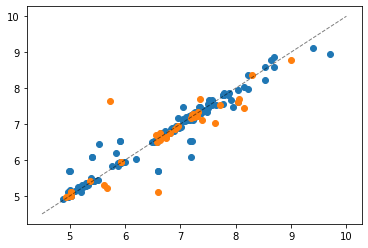

In [51]:
plt.scatter(y_train, pred_train)
plt.scatter(y_test, pred_test)

plt.plot([4.5, 10], [4.5, 10], ls='--', c='k', alpha=0.5, lw=1)

In [52]:
feat_importances = model.feature_importances_

# the metals seem to be much more important in determining the stability than do 
# either of the molecular cations or the halogens
for name, val in zip(X_columns, feat_importances):
    print(name, val)

alkyne-nHeavyAtom 0.0004963942130838924
alkyne-nHetero 0.1434147856577148
alkyne-C1SP2 0.09077540200660347
alkyne-C2SP2 0.015414696598360306
alkyne-C3SP2 0.0017040988437470217
alkyne-C1SP3 0.0019777706108445128
alkyne-SLogP 0.005587041679752024
alkyne-HybRatio 0.0024039529686256294
alkyne-nHBDon 0.0011901046654716474
alkyne-apol 0.016175502037838328
alkyne-bpol 0.22561094079941882
alkyne-nRot 0.0003656442314994936
alkyne-RotRatio 0.00028422051815444097
alkyne-TopoPSA 0.046986586828624125
alkyne-Diameter 0.0031004833672786396
alkyne-Radius 0.00042051227888872375
alkyne-MW 0.010346772645945376
template-nHeavyAtom 0.014219795125927337
template-nHetero 0.035610792073447826
template-C1SP2 0.00344705788380352
template-C2SP2 0.04420598033771182
template-C3SP2 0.002162677594673455
template-C1SP3 0.0613436756545942
template-SLogP 0.04232610741412367
template-HybRatio 0.02794997335052668
template-nHBDon 0.0016726552649132054
template-apol 0.03125466138952069
template-bpol 0.05766796732191453
tem